### 写在前面的话
受[大作业](https://aistudio.baidu.com/aistudio/projectdetail/2270454)的启发，将`.npy`转为类似格式的文件运行训练。  发现`.npy`似乎有些对应不上，遂找到原来的图像文件进行训练。  
目前只是依样画葫芦，很多参数设置等等还不明所以。  
我明白我自己的水平还远远不够，会不断探索。  
另，本项目需GPU环境

### 数据集说明
共有10个文件夹，共2062个文件，分别为0—9十个数字，对应相应的手势。  
图片大小为100像素×100像素，分辨率为72dpi，颜色模式为RGB模式。  

目录结构  
```
dataset/
├── 0
│   ├── IMG_5950.jpg
│   ├── IMG_4496.jpg
│   ├── IMG_4926.jpg
├── 1
├── 2
├── 3
├── 4
├── 5
├── 6
├── 7
├── 8
├── 9
├── 10
```

In [22]:
%cd ./home/studio/

/home/aistudio


In [23]:
# 解压数据集
!unzip -oq /home/aistudio/data/data104441/Sign-language-digits-dataset.zip -d digit_sign

In [6]:
# 加载相应库
from sklearn.utils import shuffle
import os
import pandas as pd
import numpy as np
from PIL import Image
import paddle
import paddle.nn as nn
import random

In [14]:
config = {
    'dirpath': "digit_sign", #数据集根目录（一分类一个文件夹）
    'train_ratio': 0.8, #训练集占80%
    'batch_size': 32, #批次大小
    'learning_rate': 0.001, #学习率
    'num_epoch': 100, #训练轮次
}

In [24]:
# 分割为训练集test和验证集val
# 得到总的训练数据
def read_all_files():
    all_list = []
    i = 0 # 标记总文件数量
    j = 0 # 标记文件类别
    for root,dirs,files in os.walk(config['dirpath']): # 分别代表根目录、文件夹、文件
        for file in files:
            i = i + 1 
            # 文件中每行格式： 图像相对路径      图像的label_id（数字类别）（注意：中间有空格）。              
            imgpath = os.path.join(root,file)
            all_list.append(imgpath+" "+str(j)+"\n")
        j = j + 1
    allstr = ''.join(all_list)
    with open('all_list.txt','w',encoding='utf-8') as f:
        f.write(allstr)
    return all_list , i

all_list,all_lenth = read_all_files()
print('总训练数据有{}条'.format(all_lenth))       

# 把数据打乱
all_list = shuffle(all_list)
allstr = ''.join(all_list)
with open('all_list.txt','w',encoding='utf-8') as f:
    f.write(allstr)
print("打乱成功，并重新写入文本")

# 按照比例划分数据集
train_size = int(all_lenth * config['train_ratio'])
train_list = all_list[:train_size]
val_list = all_list[train_size:]

print('训练集大小为{}, 验证集大小为{}'.format(len(train_list), len(val_list)))

# 生成训练集txt 
train_txt = ''.join(train_list)
with open('train_list.txt','w',encoding='utf-8') as f_train:
    f_train.write(train_txt)
    print("train_list.txt 生成成功！")

# 生成验证集txt
val_txt = ''.join(val_list)
with open('val_list.txt','w',encoding='utf-8') as f_val:
    f_val.write(val_txt)
    print("val_list.txt 生成成功！")

总训练数据有2062条
打乱成功，并重新写入文本
训练集大小为1649, 验证集大小为413
train_list.txt 生成成功！
val_list.txt 生成成功！


In [9]:
# 安装PaddleClas
!git clone https://gitee.com/paddlepaddle/PaddleClas.git -b release/2.2

Cloning into 'PaddleClas'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (538/538), done.
remote: Compressing objects: 100% (323/323), done.
remote: Total 15290 (delta 347), reused 349 (delta 210), pack-reused 14752
Receiving objects: 100% (15290/15290), 113.56 MiB | 16.67 MiB/s, done.
Resolving deltas: 100% (10239/10239), done.
Checking connectivity... done.


In [26]:
# 后续paddleclas的命令需要在PaddleClas目录下，所以进入PaddleClas根目录
# 并把数据都移到相应文件夹下
%cd PaddleClas
!ls

/home/aistudio/PaddleClas
dataset  hubconf.py   MANIFEST.in    README_ch.md  requirements.txt
deploy	 __init__.py  paddleclas.py  README_en.md  setup.py
docs	 LICENSE      ppcls	     README.md	   tools


In [27]:
!mv ../digit_sign/ dataset/

In [28]:
# 挪动文件到对应目录
!mv ../all_list.txt dataset/digit_sign
!mv ../train_list.txt dataset/digit_sign
!mv ../val_list.txt dataset/digit_sign

### 相关设置
主要是以下几点：分类数、图片总量、训练和验证的路径、图像尺寸、数据预处理、训练和预测的num_workers: 0

路径如下：
>PaddleClas/ppcls/configs/quick_start/new_user/ShuffleNetV2_x0_25.yaml

目前根据config更改了相应文件的相应内容，记得用快捷键`Ctrl+F`更好地找到修改
```
# global configs
Global:
  checkpoints: null
  pretrained_model: null
  output_dir: ./output/
  # 使用GPU训练
  device: gpu
  # 每几个轮次保存一次
  save_interval: 1 
  eval_during_train: True
  # 每几个轮次验证一次
  eval_interval: 1 
  # 训练轮次
  epochs: 100
  print_batch_step: 1
  use_visualdl: True #开启可视化（目前平台不可用）
  # used for static mode and model export
  # 图像大小
  image_shape: [3, 100, 100] 
  save_inference_dir: ./inference
  # training model under @to_static
  to_static: False

# model architecture
Arch:
  # 采用的网络
  name: ResNet50
  # 类别数 多了个0类 1-10对应数字0-9 0无用 
  class_num: 11
 
# loss function config for traing/eval process
Loss:
  Train:

    - CELoss: 
        weight: 1.0
  Eval:
    - CELoss:
        weight: 1.0


Optimizer:
  name: Momentum
  momentum: 0.9
  lr:
    name: Piecewise
    learning_rate: 0.001
    decay_epochs: [30, 60, 90]
    values: [0.1, 0.01, 0.001, 0.0001]
  regularizer:
    name: 'L2'
    coeff: 0.0005


# data loader for train and eval
DataLoader:
  Train:
    dataset:
      name: ImageNetDataset
      # 根路径
      image_root: ./dataset/
      # 前面自己生产得到的训练集文本路径
      cls_label_path: ./dataset/digit_sign/train_list.txt
      # 数据预处理
      transform_ops:
        - DecodeImage:
            to_rgb: True
            channel_first: False
        - ResizeImage:
            resize_short: 128
        - CropImage:
            size: 100
        - RandFlipImage:
            flip_code: 1
        - NormalizeImage:
            scale: 1.0/127.0
            mean: [0.485, 0.456, 0.406]
            std: [0.229, 0.224, 0.225]
            order: ''

    sampler:
      name: DistributedBatchSampler
      batch_size: 32
      drop_last: False
      shuffle: True
    loader:
      num_workers: 0
      use_shared_memory: True

  Eval:
    dataset: 
      name: ImageNetDataset
      # 根路径
      image_root: ./dataset/
      # 前面自己生产得到的验证集文本路径
      cls_label_path: ./dataset/digit_sign/val_list.txt
      # 数据预处理
      transform_ops:
        - DecodeImage:
            to_rgb: True
            channel_first: False
        - ResizeImage:
            resize_short: 128
        - CropImage:
            size: 100
        - NormalizeImage:
            scale: 1.0/127.0
            mean: [0.485, 0.456, 0.406]
            std: [0.229, 0.224, 0.225]
            order: ''
    sampler:
      name: DistributedBatchSampler
      batch_size: 32
      drop_last: False
      shuffle: True
    loader:
      num_workers: 0
      use_shared_memory: True

Infer:
  infer_imgs: ./dataset/digit_sign/0/IMG_5950.jpg
  batch_size: 10
  transforms:
    - DecodeImage:
        to_rgb: True
        channel_first: False
    - ResizeImage:
        resize_short: 128
    - CropImage:
        size: 100
    - NormalizeImage:
        scale: 1.0/127.0
        mean: [0.485, 0.456, 0.406]
        std: [0.229, 0.224, 0.225]
        order: ''
    - ToCHWImage:
  PostProcess:
    name: Topk
    # 输出的可能性最高的前topk个
    topk: 5
    # 标签文件 需要自己新建文件
    class_id_map_file: ./dataset/label_list.txt

Metric:
  Train:
    - TopkAcc:
        topk: [1, 5]
  Eval:
    - TopkAcc:
        topk: [1, 5]
```

### 创建标签文件  
安装完paddleClas后要在dataset里面创建label_list.txt文件，内容如下所示(根据all_list.txt的内容对应，左边是标签，右边是实际内容，每次都需要更改)。

```
1 8
2 2
3 3
4 7
5 9
6 6
7 5
8 4
9 1
10 0

```

In [29]:
# 开始训练
!python3 tools/train.py \
    -c ./ppcls/configs/quick_start/new_user/ShuffleNetV2_x0_25.yaml

In [31]:
# 更换为你训练的网络，需要预测的文件，上面训练所得到的的最优模型文件
# 尝试预测
!python3 tools/infer.py \
    -c ./ppcls/configs/quick_start/new_user/ShuffleNetV2_x0_25.yaml \
    -o Infer.infer_imgs=./dataset/digit_sign/0/IMG_4856.JPG \
    -o Global.pretrained_model=output/ResNet50/best_model

/home/aistudio/PaddleClas/ppcls/arch/backbone/model_zoo/vision_transformer.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable
[2021/08/15 21:39:48] root INFO: 
==        PaddleClas is powered by PaddlePaddle !        ==
==                                                       ==
==   For more info please go to the following website.   ==
==                                                       ==
==       https://github.com/PaddlePaddle/PaddleClas      ==

[2021/08/15 21:39:48] root INFO: Arch : 
[2021/08/15 21:39:48] root INFO:     class_num : 11
[2021/08/15 21:39:48] root INFO:     name : ResNet50
[2021/08/15 21:39:48] root INFO: DataLoader : 
[2021/08/15 21:39:48] root INFO:     Eval : 
[2021/08/15 21:39:48] root INFO:         dataset : 
[2021/08/15 21:39:48] root INFO:             cls_label_path : ./dataset/digit_sign/val_list.txt
[2021/08/15 21

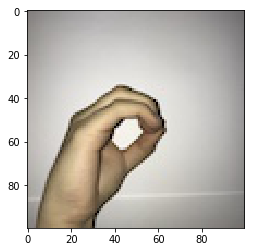

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
img = mpimg.imread('./dataset/digit_sign/0/IMG_4856.JPG')
plt.imshow(img)

运行完成，最后几行会得到结果如下形式：
```
[{'class_ids': [10, 9, 5, 2, 6], 
'scores': [0.96683, 0.03309, 8e-05, 0.0, 0.0], 
'file_name': './dataset/digit_sign/0/IMG_4856.JPG', 
'label_names': ['0', '1', '9', '2', '6']}]
``` 
这说明最大可能是0，通过图片我们也能看出来确实如此。